In [1]:
from pathlib import Path
import os
import pandas as pd
import sys
import requests
from functools import partial

import torch
import torchvision
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch 
from einops import rearrange, repeat
from loguru import logger
from torchmetrics import Metric, BootStrapper
import matplotlib.pyplot as plt
from PIL import Image
import pickle
import seaborn as sns
from matplotlib.pyplot import figure
from cka import gram, centering_mat, centered_gram, unbiased_hsic_xy, MinibatchCKA, HookedCache, make_pairwise_metrics, update_metrics, get_simmat_from_metrics
import numpy as np
import re

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import timm
from torch.utils.tensorboard import SummaryWriter

sys.path.append('..')
sys.path.append('../dino')
sys.path.append('../moco-v3')
import models_mae

import moco.builder
import moco.loader
import moco.optimizer

import vits
import itertools
writer = SummaryWriter()

DEVICE = torch.device('cpu')
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')

## Get similarity

In [2]:
def get_simmat(model1_details, model2_details):

    model1_name, model1_mode = model1_details
    model2_name, model2_mode = model2_details
    
    folder = "sim_mat/"
    file_name = folder + 'sim_mat_' + model1_name + '_' + model1_mode + '_' + model2_name + '_' + model2_mode + '.pkl'

    with open(file_name, 'rb') as f:
            sim_mat = pickle.load(f)
            print(file_name+' read')
    return sim_mat

In [3]:
def get_simmat2(model1_details, model2_details):

    model1_name, model1_mode = model1_details
    model2_name, model2_mode = model2_details
    
    folder = "../sim_mat/"
    file_name = folder + 'sim_mat_' + model1_name + '-' + model1_mode + '-' + model2_name + '-' + model2_mode + '.pkl'

    with open(file_name, 'rb') as f:
            sim_mat = pickle.load(f)
            print(file_name+' read')
    return sim_mat

In [10]:
names = ['MoCo-V3', 'DINO', 'MAE', 'SiameseIM', 'SimMIM']
modes = ['pretrained']

cnext = [('SiameseIM', 'pretrained'), ('SimMIM', 'pretrained')]
sim_mats = {}

prod = list(itertools.product(names, modes))
combs = list(itertools.product(prod, cnext))

for comb in combs:
    print(comb)
    try:
        sim_mats[comb] = get_simmat(*comb)
    except FileNotFoundError:
        try:
            sim_mats[comb] = get_simmat2(*comb)
        except FileNotFoundError:
            continue 

combs = list(itertools.combinations(prod, 2))
for comb in combs:
    print(comb)
    try:
            sim_mats[comb] = get_simmat(*comb)
    except FileNotFoundError:
        try:
            sim_mats[comb] = get_simmat2(*comb)
        except FileNotFoundError:
            continue

names = ['MOCOv3', 'DINO', 'MAE']
modes = ['ViT']

prod = list(itertools.product(names, modes))
combs = list(itertools.permutations(prod, 2))

for comb in combs:
    print(comb)
    try:
        sim_mats[comb] = get_simmat(*comb)
    except FileNotFoundError:
        try:
            sim_mats[comb] = get_simmat2(*comb)
        except FileNotFoundError:
            continue

(('MoCo-V3', 'pretrained'), ('SiameseIM', 'pretrained'))
sim_mat/sim_mat_MoCo-V3_pretrained_SiameseIM_pretrained.pkl read
(('MoCo-V3', 'pretrained'), ('SimMIM', 'pretrained'))
sim_mat/sim_mat_MoCo-V3_pretrained_SimMIM_pretrained.pkl read
(('DINO', 'pretrained'), ('SiameseIM', 'pretrained'))
sim_mat/sim_mat_DINO_pretrained_SiameseIM_pretrained.pkl read
(('DINO', 'pretrained'), ('SimMIM', 'pretrained'))
sim_mat/sim_mat_DINO_pretrained_SimMIM_pretrained.pkl read
(('MAE', 'pretrained'), ('SiameseIM', 'pretrained'))
sim_mat/sim_mat_MAE_pretrained_SiameseIM_pretrained.pkl read
(('MAE', 'pretrained'), ('SimMIM', 'pretrained'))
sim_mat/sim_mat_MAE_pretrained_SimMIM_pretrained.pkl read
(('SiameseIM', 'pretrained'), ('SiameseIM', 'pretrained'))
(('SiameseIM', 'pretrained'), ('SimMIM', 'pretrained'))
(('SimMIM', 'pretrained'), ('SiameseIM', 'pretrained'))
(('SimMIM', 'pretrained'), ('SimMIM', 'pretrained'))
(('MoCo-V3', 'pretrained'), ('DINO', 'pretrained'))
sim_mat/sim_mat_MoCo-V3_pretrained_DIN

In [11]:
for comb in sim_mats:
    print(comb)

(('MoCo-V3', 'pretrained'), ('SiameseIM', 'pretrained'))
(('MoCo-V3', 'pretrained'), ('SimMIM', 'pretrained'))
(('DINO', 'pretrained'), ('SiameseIM', 'pretrained'))
(('DINO', 'pretrained'), ('SimMIM', 'pretrained'))
(('MAE', 'pretrained'), ('SiameseIM', 'pretrained'))
(('MAE', 'pretrained'), ('SimMIM', 'pretrained'))
(('MoCo-V3', 'pretrained'), ('DINO', 'pretrained'))
(('MoCo-V3', 'pretrained'), ('MAE', 'pretrained'))
(('DINO', 'pretrained'), ('MAE', 'pretrained'))


In [6]:
def sim_vs_dist(sim_mat):
    dists = []
    sims = []

    for i in range(sim_mat.shape[0]):
        for j in range(sim_mat.shape[1]):
            dist = abs(i-j)
            dists.append(dist)
            sims.append(sim_mat[i][j].item())

    df = pd.DataFrame(
                        {'distance': dists,
                        'similarity': sims,
                        })        
    return df

In [7]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

In [8]:
def cka_vs_dist_plot(df, title):

    fig = figure(figsize=(9, 6), dpi=300)

    sns.boxplot(x="distance", y="similarity", data=df, palette="rocket")
    sns.regplot(x="distance", y="similarity", data=df, scatter=False, truncate=False)

    plt.xlabel("Distance between layers")
    plt.ylabel("CKA similarity")

    plt.title(title)

    plt.locator_params(axis='x', nbins=11)
    plt.show()

    return fig

In [9]:
def cka_vs_dist_error_bar_plot(df, title):

    sns.lineplot(x="distance", y="similarity", data=df, err_style="band")

    plt.xlabel("Distance between layers")
    plt.ylabel("CKA similarity")

    plt.title(title)

    plt.locator_params(axis='x', nbins=11)
    plt.show()

    return

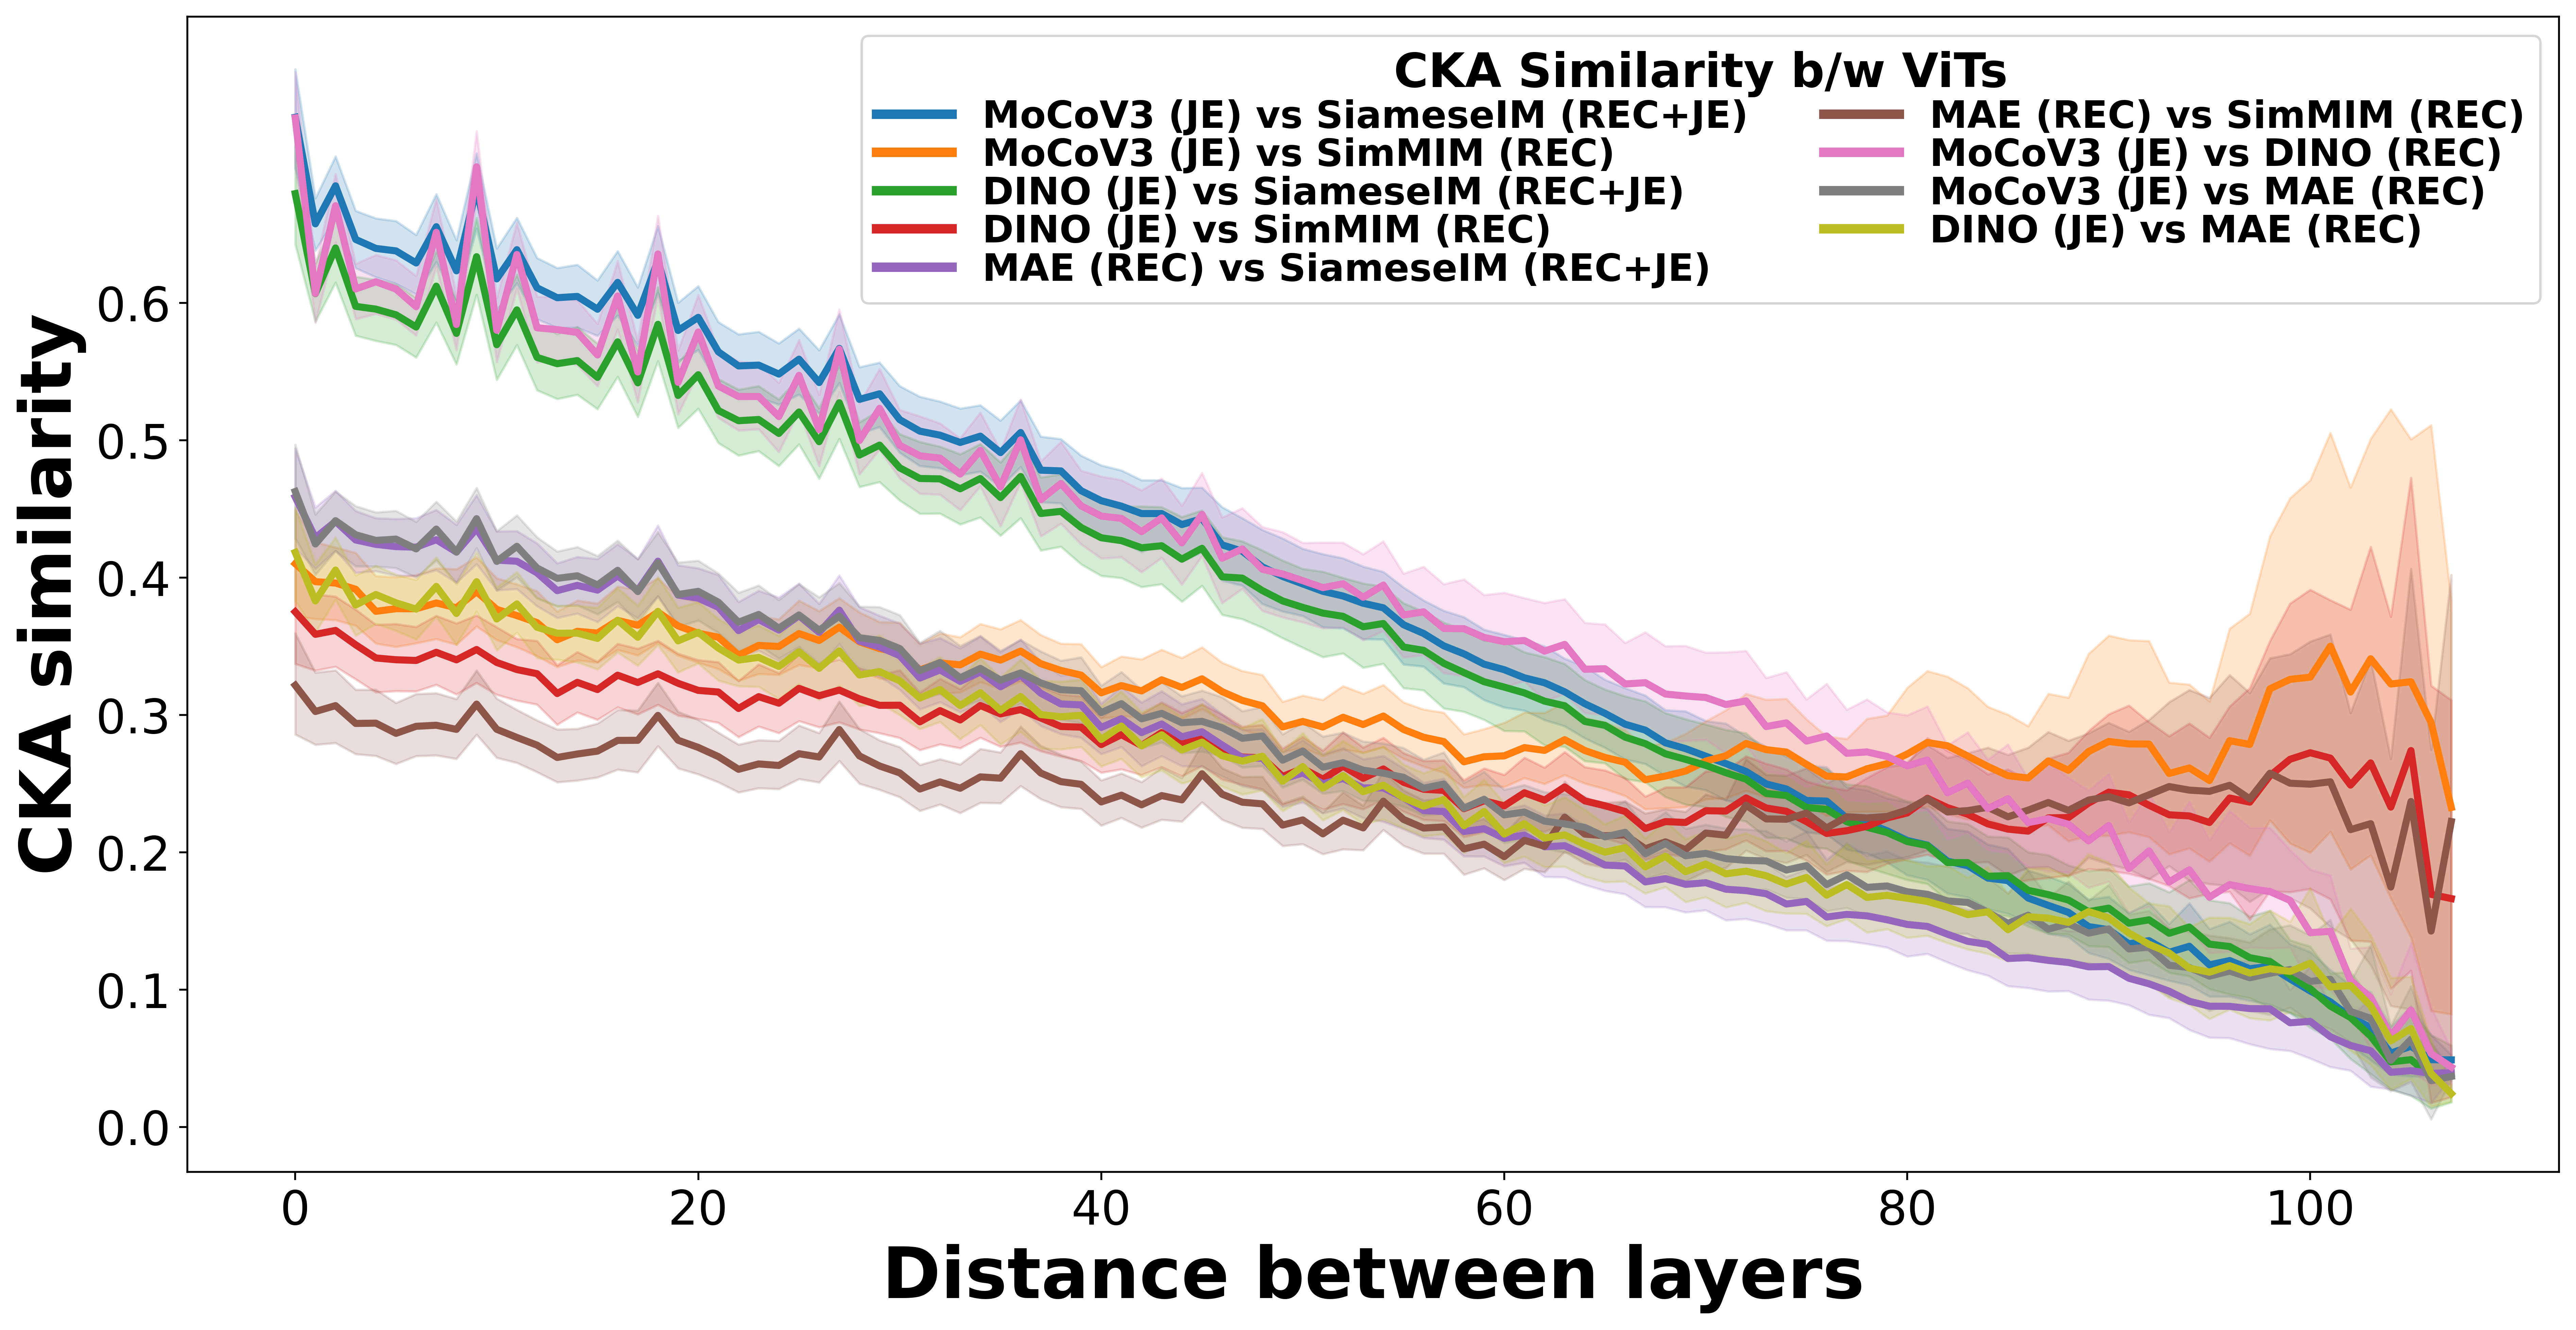

In [23]:
#(('MoCo-V3', 'pretrained'), ('SiameseIM', 'pretrained'))
#(('MoCo-V3', 'pretrained'), ('SimMIM', 'pretrained'))
#(('DINO', 'pretrained'), ('SiameseIM', 'pretrained'))
#(('DINO', 'pretrained'), ('SimMIM', 'pretrained'))
#(('MAE', 'pretrained'), ('SiameseIM', 'pretrained'))
#(('MAE', 'pretrained'), ('SimMIM', 'pretrained'))
#(('MoCo-V3', 'pretrained'), ('DINO', 'pretrained'))
#(('MoCo-V3', 'pretrained'), ('MAE', 'pretrained'))
#(('DINO', 'pretrained'), ('MAE', 'pretrained'))

fig_dir = '../figures/rebuttal/'

fig, ax = plt.subplots(figsize=(18, 9), dpi=500)

sim_mat = sim_mats[(('MoCo-V3', 'pretrained'), ('SiameseIM', 'pretrained'))]
df = sim_vs_dist(sim_mat)
sns.lineplot(x="distance", y="similarity", data=df, err_style="band", label="MoCoV3 (JE) vs SiameseIM (REC+JE)", linewidth=3)

sim_mat = sim_mats[(('MoCo-V3', 'pretrained'), ('SimMIM', 'pretrained'))]
df = sim_vs_dist(sim_mat)
sns.lineplot(x="distance", y="similarity", data=df, err_style="band", label="MoCoV3 (JE) vs SimMIM (REC)", linewidth=3)

sim_mat = sim_mats[(('DINO', 'pretrained'), ('SiameseIM', 'pretrained'))]
df = sim_vs_dist(sim_mat)
sns.lineplot(x="distance", y="similarity", data=df, err_style="band", label="DINO (JE) vs SiameseIM (REC+JE)", linewidth=3)

sim_mat = sim_mats[(('DINO', 'pretrained'), ('SimMIM', 'pretrained'))]
df = sim_vs_dist(sim_mat)
sns.lineplot(x="distance", y="similarity", data=df, err_style="band", label="DINO (JE) vs SimMIM (REC)", linewidth=3)

sim_mat = sim_mats[(('MAE', 'pretrained'), ('SiameseIM', 'pretrained'))]
df = sim_vs_dist(sim_mat)
sns.lineplot(x="distance", y="similarity", data=df, err_style="band", label="MAE (REC) vs SiameseIM (REC+JE)", linewidth=3)

sim_mat = sim_mats[(('MAE', 'pretrained'), ('SimMIM', 'pretrained'))]
df = sim_vs_dist(sim_mat)
sns.lineplot(x="distance", y="similarity", data=df, err_style="band", label="MAE (REC) vs SimMIM (REC)", linewidth=3)


sim_mat = sim_mats[(('MoCo-V3', 'pretrained'), ('DINO', 'pretrained'))]
df = sim_vs_dist(sim_mat)
sns.lineplot(x="distance", y="similarity", data=df, err_style="band", label="MoCoV3 (JE) vs DINO (REC)", linewidth=3)

sim_mat = sim_mats[(('MoCo-V3', 'pretrained'), ('MAE', 'pretrained'))]
df = sim_vs_dist(sim_mat)
sns.lineplot(x="distance", y="similarity", data=df, err_style="band", label="MoCoV3 (JE) vs MAE (REC)", linewidth=3)

sim_mat = sim_mats[(('DINO', 'pretrained'), ('MAE', 'pretrained'))]
df = sim_vs_dist(sim_mat)
sns.lineplot(x="distance", y="similarity", data=df, err_style="band", label="DINO (JE) vs MAE (REC)", linewidth=3)

ax.set_xticks(np.arange(0, 130, 20), visible=True)
ax.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6], visible=True)
ax.set_xticklabels([x for x in np.arange(0, 130, 20)], fontsize = 20)
ax.set_yticklabels([x for x in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]], fontsize = 20)

plt.xlabel("Distance between layers", fontweight="bold", fontdict={'size':30})
plt.ylabel("CKA similarity", fontweight="bold", fontdict={'size':30})
#plt.title("CKA similarity between ViT-B/16 model pairs")
legend = plt.legend(title='CKA Similarity b/w ViTs', loc='upper right', prop={'size': 16, 'weight':'bold'}, ncol=2, labelspacing=0.05)
for legobj in legend.legendHandles:
    legobj.set_linewidth(4)
plt.setp(legend.get_title(),fontsize=20, fontweight="bold")
plt.locator_params(axis='x', nbins=11)
plt.show()

fig.savefig(fig_dir+'CKA-objective-pairs.pdf', dpi=500, bbox_inches = "tight")

In [23]:
names = ['MoCo-V3', 'DINO', 'MAE']
modes = ['pretrained', 'finetuned']

cnext = [('Supervised', 'finetuned')]
sim_mats = {}

prod = list(itertools.product(names, modes))
combs = list(itertools.product(prod, cnext))

for comb in combs:
    print(comb)
    try:
        sim_mats[comb] = get_simmat(*comb)
    except FileNotFoundError:
        try:
            sim_mats[comb] = get_simmat2(*comb)
        except FileNotFoundError:
            continue 

combs = list(itertools.combinations(prod, 2))
for comb in combs:
    print(comb)
    try:
            sim_mats[comb] = get_simmat(*comb)
    except FileNotFoundError:
        try:
            sim_mats[comb] = get_simmat2(*comb)
        except FileNotFoundError:
            continue

names = ['MOCOv3', 'DINO', 'MAE']
modes = ['ViT']

prod = list(itertools.product(names, modes))
combs = list(itertools.permutations(prod, 2))

for comb in combs:
    print(comb)
    try:
        sim_mats[comb] = get_simmat(*comb)
    except FileNotFoundError:
        try:
            sim_mats[comb] = get_simmat2(*comb)
        except FileNotFoundError:
            continue

'''
folder = "../sim_mat/"
file_name = 'sim_mat_Supervised-MOCOv3.pkl'

with open(folder+file_name, 'rb') as f:
        sim_mats[(('MOCOCv3', 'pretrained'), ('Supervised', 'finetuned'))] = pickle.load(f)

file_name = 'sim_mat_Supervised-DINO.pkl'

with open(folder+file_name, 'rb') as f:
        sim_mats[(('DINO', 'pretrained'), ('Supervised', 'finetuned'))] = pickle.load(f)

file_name = 'sim_mat_Supervised-MAE.pkl'

with open(folder+file_name, 'rb') as f:
        sim_mats[(('MAE', 'pretrained'), ('Supervised', 'finetuned'))] = pickle.load(f)
'''

(('MoCo-V3', 'pretrained'), ('Supervised', 'finetuned'))
sim_mat/sim_mat_MoCo-V3_pretrained_Supervised_finetuned.pkl read
(('MoCo-V3', 'finetuned'), ('Supervised', 'finetuned'))
sim_mat/sim_mat_MoCo-V3_finetuned_Supervised_finetuned.pkl read
(('DINO', 'pretrained'), ('Supervised', 'finetuned'))
sim_mat/sim_mat_DINO_pretrained_Supervised_finetuned.pkl read
(('DINO', 'finetuned'), ('Supervised', 'finetuned'))
sim_mat/sim_mat_DINO_finetuned_Supervised_finetuned.pkl read
(('MAE', 'pretrained'), ('Supervised', 'finetuned'))
sim_mat/sim_mat_MAE_pretrained_Supervised_finetuned.pkl read
(('MAE', 'finetuned'), ('Supervised', 'finetuned'))
sim_mat/sim_mat_MAE_finetuned_Supervised_finetuned.pkl read
(('MoCo-V3', 'pretrained'), ('MoCo-V3', 'finetuned'))
sim_mat/sim_mat_MoCo-V3_pretrained_MoCo-V3_finetuned.pkl read
(('MoCo-V3', 'pretrained'), ('DINO', 'pretrained'))
sim_mat/sim_mat_MoCo-V3_pretrained_DINO_pretrained.pkl read
(('MoCo-V3', 'pretrained'), ('DINO', 'finetuned'))
sim_mat/sim_mat_MoCo-V3

'\nfolder = "../sim_mat/"\nfile_name = \'sim_mat_Supervised-MOCOv3.pkl\'\n\nwith open(folder+file_name, \'rb\') as f:\n        sim_mats[((\'MOCOCv3\', \'pretrained\'), (\'Supervised\', \'finetuned\'))] = pickle.load(f)\n\nfile_name = \'sim_mat_Supervised-DINO.pkl\'\n\nwith open(folder+file_name, \'rb\') as f:\n        sim_mats[((\'DINO\', \'pretrained\'), (\'Supervised\', \'finetuned\'))] = pickle.load(f)\n\nfile_name = \'sim_mat_Supervised-MAE.pkl\'\n\nwith open(folder+file_name, \'rb\') as f:\n        sim_mats[((\'MAE\', \'pretrained\'), (\'Supervised\', \'finetuned\'))] = pickle.load(f)\n'

In [24]:
for comb in sim_mats:
    print(comb)

(('MoCo-V3', 'pretrained'), ('Supervised', 'finetuned'))
(('MoCo-V3', 'finetuned'), ('Supervised', 'finetuned'))
(('DINO', 'pretrained'), ('Supervised', 'finetuned'))
(('DINO', 'finetuned'), ('Supervised', 'finetuned'))
(('MAE', 'pretrained'), ('Supervised', 'finetuned'))
(('MAE', 'finetuned'), ('Supervised', 'finetuned'))
(('MoCo-V3', 'pretrained'), ('MoCo-V3', 'finetuned'))
(('MoCo-V3', 'pretrained'), ('DINO', 'pretrained'))
(('MoCo-V3', 'pretrained'), ('DINO', 'finetuned'))
(('MoCo-V3', 'pretrained'), ('MAE', 'pretrained'))
(('MoCo-V3', 'pretrained'), ('MAE', 'finetuned'))
(('MoCo-V3', 'finetuned'), ('DINO', 'pretrained'))
(('MoCo-V3', 'finetuned'), ('DINO', 'finetuned'))
(('MoCo-V3', 'finetuned'), ('MAE', 'pretrained'))
(('MoCo-V3', 'finetuned'), ('MAE', 'finetuned'))
(('DINO', 'pretrained'), ('DINO', 'finetuned'))
(('DINO', 'pretrained'), ('MAE', 'pretrained'))
(('DINO', 'pretrained'), ('MAE', 'finetuned'))
(('DINO', 'finetuned'), ('MAE', 'pretrained'))
(('DINO', 'finetuned'), ('M

In [26]:
distances = {}

for comb in sim_mats:
    distances[comb] = sim_vs_dist(sim_mats[comb])

In [27]:
for comb in distances:
    print(comb, np.mean(distances[comb].similarity[distances[comb].distance==0]))

(('MoCo-V3', 'pretrained'), ('Supervised', 'finetuned')) 0.6107156346724542
(('MoCo-V3', 'finetuned'), ('Supervised', 'finetuned')) 0.6430375206249731
(('DINO', 'pretrained'), ('Supervised', 'finetuned')) 0.6007959387368627
(('DINO', 'finetuned'), ('Supervised', 'finetuned')) 0.6027013699489611
(('MAE', 'pretrained'), ('Supervised', 'finetuned')) 0.3809271420835069
(('MAE', 'finetuned'), ('Supervised', 'finetuned')) 0.6309776659365054
(('MoCo-V3', 'pretrained'), ('MoCo-V3', 'finetuned')) 0.7270562848835079
(('MoCo-V3', 'pretrained'), ('DINO', 'pretrained')) 0.7347043660227899
(('MoCo-V3', 'pretrained'), ('DINO', 'finetuned')) 0.6370255821556957
(('MoCo-V3', 'pretrained'), ('MAE', 'pretrained')) 0.4626552755082095
(('MoCo-V3', 'pretrained'), ('MAE', 'finetuned')) 0.6865506484000771
(('MoCo-V3', 'finetuned'), ('DINO', 'pretrained')) 0.6844666460873904
(('MoCo-V3', 'finetuned'), ('DINO', 'finetuned')) 0.7406870128103981
(('MoCo-V3', 'finetuned'), ('MAE', 'pretrained')) 0.4348078913020867
